# ANHIR: Evaluation Board

This notebook serves as visualisation for challenge results in several forms - standard tables and charts. First, all submissions have to be recomputed, so they also contain the detail about each image registration pair. One of the perspective to validate is the difference between training and testing.

The ANHIR challenge is hosted on https://anhir.grand-challenge.org.

These particular results are for ANHIR workshop hosted at ISBI 2019 in Venice, Italy.
In case you want to get some further evaluation related to new submission, you may contact one of the ANHIR administrators because the full submission is required, see https://anhir.grand-challenge.org/Organizers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking, grouping_cumulative
from birl.utilities.drawing import RadarChart, draw_matrix_user_ranking, draw_scatter_double_scale
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [2]:
# folder with all participants submissions
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions_paper')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
# landmarks provided to participants, in early ANHIR stage we provided only 20% points per image pair
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
# complete landmarks dataset
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
# baseline for normalization of computing time
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'
FIELD_STATUS = 'Status'

# configuration for Pandas tables
pd.set_option("display.max_columns", 25)

Some initial replacement and name adjustments

In [3]:
# Look-Up-Table for upadting plot names from original (dataset) names
TISSUE_LUT = {
    'COAD': 'COAD', 'gastric': 'gastric',
    'breast': 'human-breast', 'kidney': 'human-kidney',
    'lung-lesion': 'lung-lesion', 'lung-lobes': 'lung-lobes',
    'mammary-gland': 'mammary-gland', 'mice-kidney': 'mouse-kidney'
}
# simplify the metrics names according paper
METRIC_LUT = {
    'Average-': 'A', 
    'Rank-': 'R',
    'Median-': 'M',
    'Max-': 'Mx',
}

def col_metric_rename(col):
    for m in METRIC_LUT:
        col = col.replace(m, METRIC_LUT[m])
    return col

def col_tissue_remane(col):
    k = col.split('_')[-1]
    if k in TISSUE_LUT:
        col = col.replace(k, TISSUE_LUT[k])
    return col

## Parse and load submissions

### Extract metrics from particular submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [4]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip -o "%s" -d "%s"' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

Parse submissions and compute the final metrics. This can be computed just once.

**NOTE:** you can skip this step if you have already computed metrics in JSON files

In [5]:
import bm_ANHIR.evaluate_submission

bm_ANHIR.evaluate_submission.REQUIRE_OVERLAP_INIT_TARGET = False

tqdm_bar = tqdm.tqdm(total=len(submission_dirs))
for path_sub in submission_dirs:
    tqdm_bar.set_description(path_sub)
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_table=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1.,
        details=True,
        allow_inverse=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))
    tqdm_bar.update()

### Load parsed measures from each submission/experiment/participant

In [4]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    # rename tissue types accoding new LUT
    for case in metrics['cases']:
        metrics['cases'][case][FIELD_TISSUE] = TISSUE_LUT[metrics['cases'][case][FIELD_TISSUE]]
    m_agg = {stat: metrics['aggregates'][stat] for stat in metrics['aggregates']}
    metrics['aggregates'] = m_agg
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

Users: dict_keys(['AGH', 'ANTs', 'CKVST', 'DROP', 'Elastix', 'MEVIS', 'NiftyReg', 'RVSS', 'TUB', 'TUNI', 'UA', 'UPENN', 'bUnwarpJ'])


In [5]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['COAD', 'gastric', 'human-breast', 'human-kidney', 'lung-lesion', 'lung-lobes', 'mammary-gland', 'mouse-kidney']


## Results overview

Present simple statistic about ratios of train/test image pairs per dataset...

type-tissue,COAD,gastric,human-breast,human-kidney,lung-lesion,lung-lobes,mammary-gland,mouse-kidney
evaluation,153.0,40.0,20.0,20.0,NaN,NaN,NaN,18.0
training,84.0,13.0,5.0,5.0,30.0,40.0,38.0,15.0


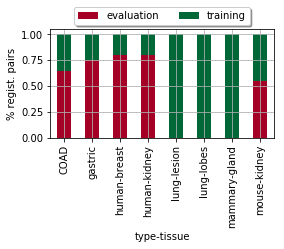

In [8]:
# add stat of train/test for tissie
df_tissue_stat = pd.DataFrame([(cs['name-tissue'], cs[FIELD_TISSUE], cs[FIELD_STATUS])
                               for cs in user_cases[users[0]].values()],
                              columns=['name', FIELD_TISSUE, FIELD_STATUS])
df_tissue_stat.set_index('name', inplace=True)

# compute cumulative stat
dfx = grouping_cumulative(df_tissue_stat, col_index=FIELD_TISSUE, col_column=FIELD_STATUS)
display(dfx.T)

# show results
# ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 3), grid=True, cmap='RdYlGn')
# _= plt.ylabel('# regist. pairs')
# ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_abs.pdf'))

# normalize over the sum of all cases
dfx = (dfx.T / dfx.T.sum().astype(float)).T
ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 2), grid=True, cmap='RdYlGn')
_= plt.ylabel('% regist. pairs')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True)
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_rltv.pdf'))

## Visual properties

Define colors and markers later used in charts

In [6]:
METHODS = sorted(submissions.keys())
METHOD_CMAP = plt.get_cmap('nipy_spectral', len(submissions))
METHOD_COLORS = {m: METHOD_CMAP(i) for i, m in enumerate(METHODS)}

def list_methods_colors(methods):
    return [METHOD_COLORS[m] for m in methods]

def cmap_methods(method):
    return METHOD_COLORS[m]

# define cyclic buffer of markers for methods
# https://matplotlib.org/3.1.1/api/markers_api.html
METHOD_MARKERS = dict(zip(submissions.keys(), list('.*^v<>pPhHXdD')))
# METHOD_MARKERS = dict(zip(submissions.keys(), list('.1234+xosD^v<>')))

def list_methods_markers(methods):
    return [METHOD_MARKERS[m] for m in methods]

display(pd.DataFrame([METHOD_COLORS, METHOD_MARKERS]).T)

,0,1
AGH,"(0.0, 0.0, 0.0, 1.0)",.
ANTs,"(0.5111, 0.0, 0.577766666667, 1.0)",*
CKVST,"(0.0, 0.0, 0.733366666667, 1.0)",^
DROP,"(0.0, 0.4667, 0.8667, 1.0)",v
Elastix,"(0.0, 0.644466666667, 0.733366666667, 1.0)",<
MEVIS,"(0.0, 0.644466666667, 0.355533333333, 1.0)",>
NiftyReg,"(0.0, 0.7333, 0.0, 1.0)",p
RVSS,"(0.0, 0.955566666667, 0.0, 1.0)",P
TUB,"(0.799966666667, 0.977766666667, 0.0, 1.0)",h
TUNI,"(1.0, 0.8, 0.0, 1.0)",H


In [7]:
def _format_ax(ax, name, use_log=False, vmax=None):
    plt.xticks(rotation=60)
    if use_log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.get_figure().tight_layout()

## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [8]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    # Compute ranking per user in selected metric `field` over all dataset
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        # iterate over Robust or all cases
        for robust in [True, False]:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
            user_aggreg[user]['STD-Rank-' + field_agg + s_robust] = np.std(vals)
        # iterate over all tissue kinds
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '__tissue_' + tissue + '__All'] = np.mean(vals)
            user_aggreg[user]['STD-Rank-' + field_agg + '__tissue_' + tissue + '__All'] = np.std(vals)

## Presenting visual results

Show the raw table with **global** statistic (joint training and testing/evaluation).

In [11]:
cols_all = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_'])]
cols_general = list(filter(lambda c: not c.endswith('-Robust'), cols_all))
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]
display(dfx)
# Exporting results to CSV
dfx.sort_values('Average-Median-rTRE').to_csv(os.path.join(PATH_TEMP, 'results_overall.csv'))

,Average-Average-rTRE,Average-Max-rTRE,Average-Median-rTRE,Average-Norm-Time,Average-Rank-Max-rTRE,Average-Rank-Median-rTRE,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Max-rTRE,Median-Median-rTRE,Median-Norm-Time,Median-Robustness
UPENN,0.004057,0.023043,0.002790,1.451193,4.234927,3.403326,0.988797,1.0,0.003009,0.017465,0.001918,1.374846,1.000000
AGH,0.005636,0.030005,0.003804,6.863679,6.226611,3.567568,0.977013,1.0,0.003395,0.023059,0.001973,5.791019,1.000000
MEVIS,0.005191,0.026069,0.003852,0.145392,4.825364,2.979210,0.984455,1.0,0.002889,0.018566,0.001815,0.141754,1.000000
TUB,0.004731,0.014927,0.004099,0.000705,2.465696,2.844075,0.991911,1.0,0.001203,0.004634,0.001021,0.000510,1.000000
CKVST,0.006044,0.026128,0.004609,7.127142,5.825364,6.280665,0.973015,1.0,0.004652,0.020775,0.003314,7.488842,1.000000
TUNI,0.010363,0.038723,0.008724,10.320549,6.370062,5.993763,0.889920,1.0,0.003719,0.023399,0.002501,8.977965,1.000000
RVSS,0.047089,0.103180,0.045024,4.723187,8.523909,9.640333,0.795752,1.0,0.007098,0.029411,0.005490,4.881740,0.987500
UA,0.056887,0.119045,0.054878,1.470925,8.912682,10.137214,0.807619,1.0,0.010979,0.035972,0.009043,1.367489,0.973684
DROP,0.061602,0.122958,0.061336,3.406355,7.288981,6.869023,0.886052,1.0,0.004340,0.026460,0.002796,3.388050,0.990654
Elastix,0.069476,0.137054,0.068433,2.962337,8.798337,9.831601,0.766790,1.0,0.007977,0.038993,0.005409,2.682059,0.970588


Only **robust** metrics (computed over images pairs with robustness higher then a threshold)

In [12]:
cols_robust = list(filter(lambda c: c.endswith('-Robust'), cols_all))
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_robust]
dfx.columns = list(map(lambda c: c.replace('-Robust', ''), dfx.columns))
display(dfx)

,Average-Average-rTRE,Average-Max-rTRE,Average-Median-rTRE,Average-Norm-Time,Average-Rank-Max-rTRE,Average-Rank-Median-rTRE,Median-Average-rTRE,Median-Max-rTRE,Median-Median-rTRE,Median-Norm-Time
UPENN,0.004057,0.023043,0.002790,1.451193,4.234927,3.403326,0.003009,0.017465,0.001918,1.374846
AGH,0.005610,0.029932,0.003777,6.860032,6.226611,3.567568,0.003381,0.023048,0.001968,5.787261
MEVIS,0.004320,0.024423,0.002923,0.145501,4.825364,2.979210,0.002888,0.018537,0.001811,0.141826
TUB,0.003539,0.013330,0.002890,0.000706,2.445833,2.822917,0.001169,0.004472,0.001016,0.000510
CKVST,0.005891,0.025866,0.004451,7.146332,5.825364,6.280665,0.004634,0.020768,0.003313,7.503305
TUNI,0.007183,0.033379,0.005647,9.131541,5.810069,5.395881,0.003350,0.020732,0.002225,8.767961
RVSS,0.012546,0.042371,0.010725,5.072646,8.033254,9.289786,0.005474,0.024088,0.004165,5.169940
UA,0.016040,0.045178,0.014523,1.464565,8.721133,10.002179,0.008984,0.031842,0.007342,1.372182
DROP,0.032903,0.076700,0.032100,3.465610,7.172340,6.748936,0.003880,0.023597,0.002558,3.415281
Elastix,0.042368,0.098012,0.040490,3.239014,8.704741,9.778017,0.005424,0.028498,0.004064,2.919051


Define coloer and markers per method which shall be used later...

In [22]:
col_ranking = 'Average-Rank-Median-rTRE'
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": %s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE": ['TUB', 'MEVIS', 'UPENN', 'AGH', 'TUNI', 'CKVST', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


Show general results in a chart...

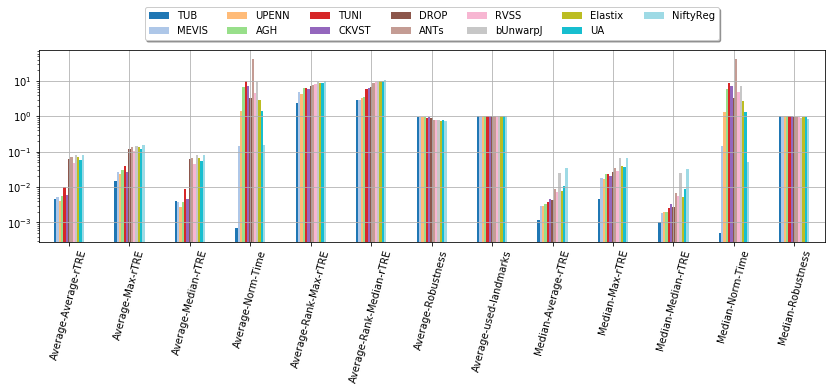

In [14]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[list(filter(lambda c: not c.startswith('STD-'), cols_general))]
ax = dfx.T.plot.bar(figsize=(len(cols_general) * 0.9, 6), grid=True, logy=True, rot=75, cmap=plt.cm.tab20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_teams-scores.pdf'))
# plt.savefig(os.path.join(PATH_TEMP, 'fig_teams-scores.pdf'), constrained_layout=True)

### Compare statistic "train" vs "test"

Compute statistics on training and testing case also foor newly add rank measures.

In [9]:
for field, field_agg in [# ('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Median_rank', 'Rank-Median-rTRE'),
                         # ('rTRE-Max', 'Max-rTRE'),
                         ('rTRE-Max_rank', 'Rank-Max-rTRE'),
                         # ('Norm-Time_minutes', 'Norm-Time'),
                        ]:
    for user in users:
        for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
            # filter values per user, metric and state
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user]['Average-' + field_agg + '_' + state] = np.nanmean(vals)

With given methods order them by particular criterion... Test ARMrTRE

In [10]:
col_ranking = 'Average-Rank-Median-rTRE_' + VAL_STATUS_TEST
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": \n%s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE_evaluation": 
['MEVIS', 'AGH', 'UPENN', 'CKVST', 'TUB', 'TUNI', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


In [11]:
df = pd.DataFrame(user_aggreg).T
cols_train_test = [col for col in df.columns 
                   if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]) and '_tissue_' not in col]
print (cols_train_test)

['Average-Average-rTRE_evaluation', 'Average-Average-rTRE_training', 'Median-Average-rTRE_evaluation', 'Median-Average-rTRE_training', 'Average-Median-rTRE_evaluation', 'Average-Median-rTRE_training', 'Median-Median-rTRE_evaluation', 'Median-Median-rTRE_training', 'Average-Max-rTRE_evaluation', 'Average-Max-rTRE_training', 'Median-Max-rTRE_evaluation', 'Median-Max-rTRE_training', 'Average-Robustness_evaluation', 'Average-Robustness_training', 'Median-Robustness_evaluation', 'Median-Robustness_training', 'Average-Rank-Median-rTRE_training', 'Average-Rank-Median-rTRE_evaluation', 'Average-Rank-Max-rTRE_training', 'Average-Rank-Max-rTRE_evaluation']


Show separatly raw table with statistic for train and test cases separatly.

In [18]:
from IPython.display import display

df_train_eval = pd.DataFrame()

for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in cols_train_test if state in col]
    df = pd.DataFrame(user_aggreg).T[cols]
    df.columns = list(map(lambda c: c.replace('_' + state, ''), df.columns))
    df['state'] = state
    df_train_eval = pd.concat([df_train_eval, df])

# df = pd.DataFrame(user_aggreg).T[cols]
# cols = [c for c in df_all_train_eval.columns if 'state' not in c and c in df.columns]
# df = df[cols]
# df['state'] = 'all'
# df_all_train_eval = pd.concat([df_all_train_eval, df])

df_train_eval['method'] = df_train_eval.index
df_train_eval = df_train_eval.set_index(['method', 'state']).sort_index()
df_train_eval.to_csv(os.path.join(PATH_TEMP, 'results-methods_tran-test.csv'))
display(df_train_eval)

Average-Average-rTRE  Average-Max-rTRE  Average-Median-rTRE  Average-Rank-Max-rTRE  Average-Rank-Median-rTRE  Average-Robustness  Median-Average-rTRE  Median-Max-rTRE  Median-Median-rTRE  Median-Robustness
method   state                                                                                                                                                                                                                    
AGH      evaluation              0.005283          0.028339             0.003587               6.000000                  3.422311            0.982096             0.003220         0.022489            0.001913           1.000000
         training                0.006021          0.031823             0.004042               6.473913                  3.726087            0.971467             0.003656         0.023500            0.002023           1.000000
ANTs     evaluation              0.099126          0.186060             0.099164               7.788845                  9.231076            0.788870             0.007222         0.035078            0.005799           0.971429
         training                0.036797          0.077806             0.035289               7.895652                  8.826087            0.840831             0.009663         0.037072            0.007837           0.974192
CKVST    evaluation              0.004294          0.023934             0.002693               5.274900                  4.406375            0.988340             0.003234         0.018857            0.002258           1.000000
         training                0.007955          0.028522             0.006701               6.426087                  8.326087            0.956290             0.006027         0.022732            0.005048           1.000000
DROP     evaluation              0.086123          0.164415             0.086654               7.430279                  7.055777            0.882477             0.004216         0.027342            0.002780           0.989247
         training                0.034842          0.077716             0.033706               7.134783                  6.665217            0.889953             0.004641         0.025512            0.002800           0.996403
Elastix  evaluation              0.096407          0.185674             0.095648               8.876494                 10.043825            0.847687             0.007354         0.035312            0.005397           0.972222
         training                0.040086          0.083994             0.038734               8.713043                  9.600000            0.678507             0.008457         0.041956            0.005506           0.959184
MEVIS    evaluation              0.004361          0.025107             0.002870               5.035857                  2.840637            0.988025             0.002740         0.018827            0.001790           1.000000
         training                0.006096          0.027120             0.004924               4.595652                  3.130435            0.980559             0.002964         0.018286            0.001857           1.000000
NiftyReg evaluation              0.111982          0.201039             0.113601              10.083665                 11.075697            0.742689             0.037248         0.071369            0.035508           0.851852
         training                0.050301          0.097324             0.049148              10.152174                 10.430435            0.756907             0.033469         0.067267            0.031194           0.850657
RVSS     evaluation              0.047214          0.104800             0.044767               8.418327                  9.649402            0.815460             0.006302         0.027516            0.004587           0.992806
         training                0.046953          0.101412             0.045304               8.639130                  9.630435            0.774246             

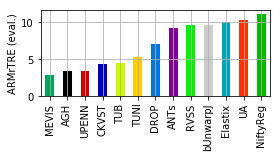

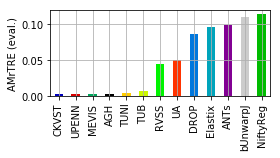

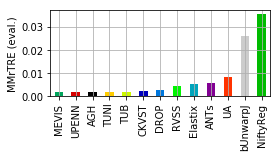

In [13]:
for col, name in [('Average-Rank-Median-rTRE_evaluation', 'ARMrTRE (eval.)'),
                  ('Average-Median-rTRE_evaluation', 'AMrTRE (eval.)'),
                  ('Median-Median-rTRE_evaluation', 'MMrTRE (eval.)')]:
    plt.figure(figsize=(4, 2.3))
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col].sort_values()
    ax = dfx.plot.bar(grid=True, rot=90, color=list_methods_colors(dfx.index))
    # ax = pd.DataFrame(user_aggreg).T.sort_values(col)[col].plot.bar(grid=True, rot=90, color='blue')
    _= plt.ylabel(name)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bar_teams-scores_%s.pdf' % col))

### Compute tables with all cases

Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [14]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['method'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()
del dfs_cases

for col in df_cases.columns:
    try:
        df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception:
        print('skip not numerical column: "%s"' % col)
# df_cases.head()

skip not numerical column: "name-tissue"
skip not numerical column: "type-tissue"
skip not numerical column: "name-reference"
skip not numerical column: "name-source"
skip not numerical column: "Status"
skip not numerical column: "method"


### Showing several distribution plots

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


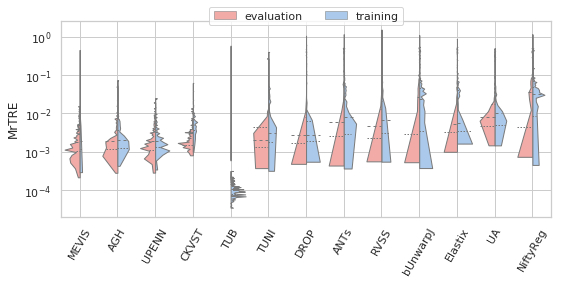

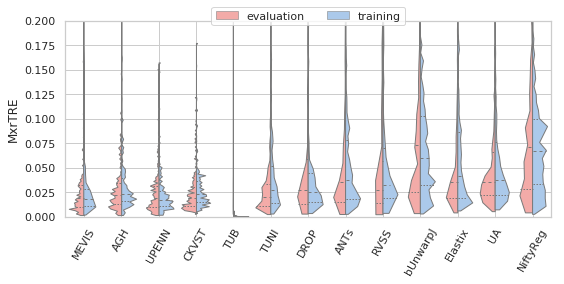

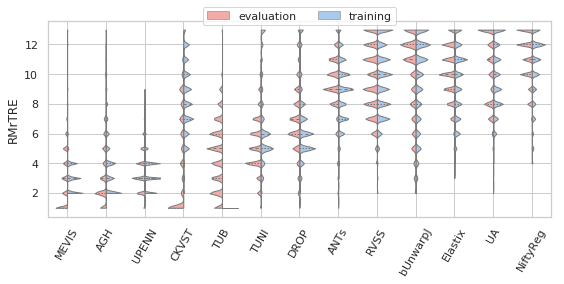

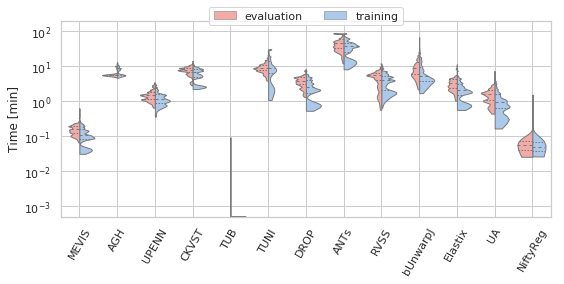

In [22]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median', '', False, 0.1, 0.01),
                                   ('rTRE-Max', 'MxrTRE', False, 0.2, 0.02),
                                   ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 200, 0.1)]:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(ax=ax, data=df_cases, hue='Status', y=field, x='method', order=users_ranked,
                   cut=0, split=True, bw=bw, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1.)
    _format_ax(ax, name, log, vmax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, shadow=False)
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'hist_teams-scores_%s.pdf' % field))

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


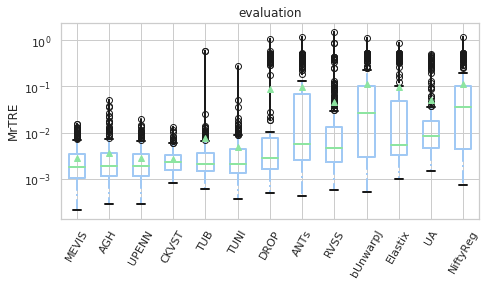

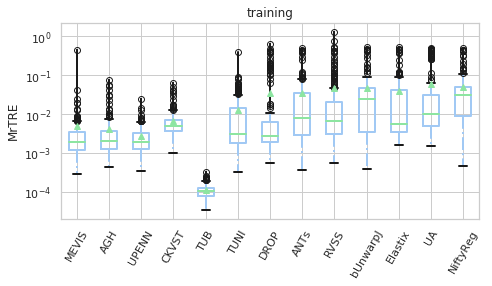

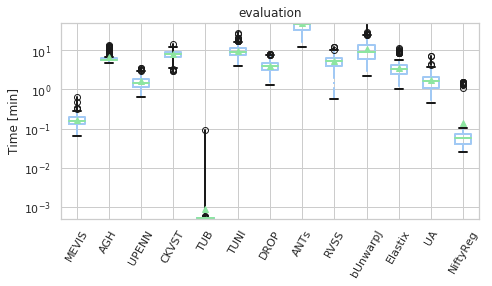

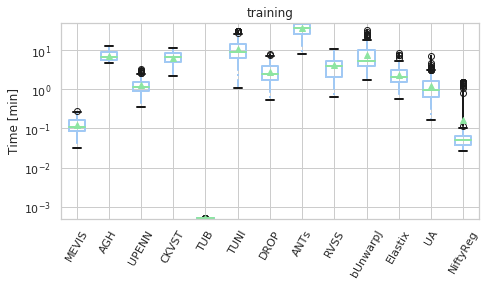

In [23]:
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 50, 0.1)]:
    for st, dfg in df_cases.groupby(FIELD_STATUS):
        # methods_ = list(dfg['method'].unique())
        vals_ = [dfg[dfg['method'] == m][field].values for m in users_ranked]
        dfg_ = pd.DataFrame(np.array(vals_).T, columns=users_ranked)
        fig, ax = plt.subplots(figsize=(7, 4))
        bp = dfg_.plot.box(ax=ax, showfliers=True, showmeans=True, 
                           color=dict(boxes='b', whiskers='b', medians='g', caps='k'),
                           boxprops=dict(linestyle='-', linewidth=2),
                           flierprops=dict(linestyle='-', linewidth=2),
                           medianprops=dict(linestyle='-', linewidth=2),
                           whiskerprops=dict(linestyle='-.', linewidth=2),
                           capprops=dict(linestyle='-', linewidth=2),
                           return_type='dict')
        _format_ax(ax, name, log, vmax)
        ax.set_title(st)
        ax.get_figure().savefig(os.path.join(PATH_TEMP, 'boxbar_teams-scores_%s_%s.pdf' % (field, st)))

### Visualise overview results

/home/jb/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


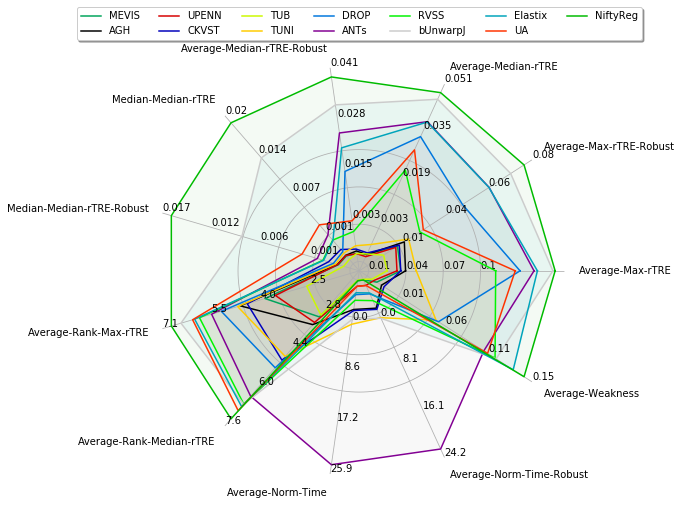

In [11]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg)[users_ranked].T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(7, 6)), colors=list_methods_colors(df.index))
radar.ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
                ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
radar.fig.tight_layout()
radar.fig.savefig(os.path.join(PATH_TEMP, 'radar_teams-scores.pdf'))

### Visualise partial rankings

With given metrics compute ranking among all participants, so each user has a unique colour and then the users are sorted in ascending order...

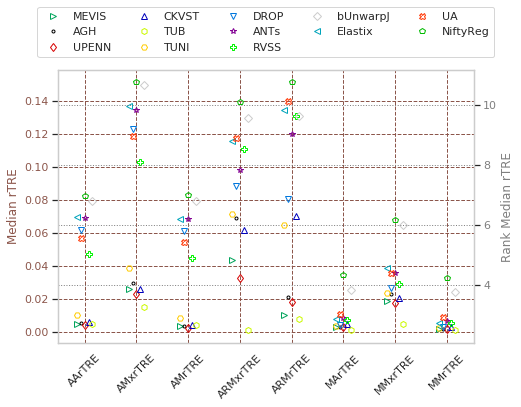

In [25]:
cols = list(filter(lambda c: not any([n in c for n in ('Robust', 'Time', 'landmarks')]), cols_general))
# cols = ['Average-Rank-Median-rTRE', 'Average-Median-rTRE', 'Average-Max-rTRE']
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]

cols_rank = list(filter(lambda c: 'Rank-' in c, cols))
# https://matplotlib.org/3.1.1/api/markers_api.html
fig, extras = draw_scatter_double_scale(
    dfx, colors=list_methods_colors(users_ranked), ax_decs={'Median rTRE': None, 'Rank Median rTRE': cols_rank},
    idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 0.8, 6),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5),
    plot_style=dict(markerfacecolor="None"))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2, 4), grid=True)
# _= plt.xlim([-0.5, len(cols) - 0.5])
# _= plt.yscale('log'), plt.ylabel('Median-rTRE [%]')

# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
# _= plt.xticks(range(len(cols)), [col_metric_rename(c) for c in cols], rotation=90)
extras['ax1'].set_xlabel('')
extras['ax1'].set_xticks(range(len(cols)))
extras['ax1'].set_xticklabels(list(map(col_metric_rename, cols)), rotation=45, ha="center")
# ax.legend(, fancybox=True, shadow=True)
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores.pdf'),
            bbox_extra_artists=(extras['legend'],), bbox_inches='tight')

Show scatters for rTRE and Rank measures separatly

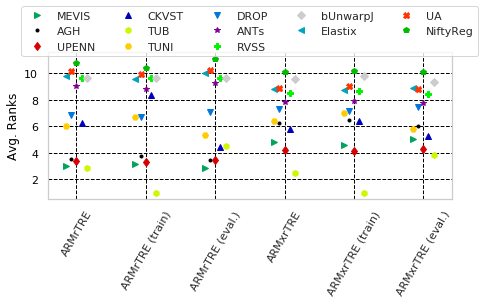

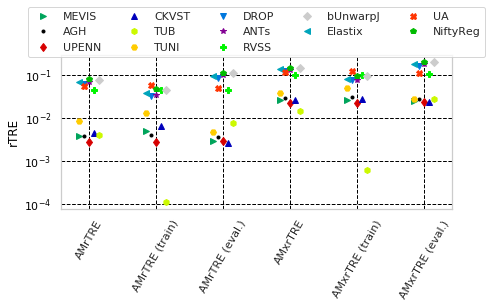

In [26]:
def _ext_cname(col):
    return [col + st for st in ('', '_' + VAL_STATUS_TRAIN, '_' + VAL_STATUS_TEST)]
def _drop_cname(col):
    return col.replace('_' + VAL_STATUS_TRAIN, ' (train)').replace('_' + VAL_STATUS_TEST, ' (eval.)')

for cols, desc, use_log in [(_ext_cname('Average-Rank-Median-rTRE') + _ext_cname('Average-Rank-Max-rTRE'), 'Avg. Ranks', False),
                            (_ext_cname('Average-Median-rTRE') + _ext_cname('Average-Max-rTRE'), 'rTRE', True)]:
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]
    # colors = plt.get_cmap('nipy_spectral', len(dfx))
    fig, extras = draw_scatter_double_scale(
        dfx, colors=list_methods_colors(users_ranked), ax_decs={desc: None},
        idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 1., 5),
        legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
    extras['ax1'].set_xticks(range(len(cols)))
    extras['ax1'].set_xticklabels(list(map(lambda c: col_metric_rename(_drop_cname(c)), cols)), rotation=45, ha="center")
    _format_ax(extras['ax1'], desc, use_log, vmax=None)
    name = ''.join(filter(lambda s: s not in '(.)', desc)).replace(' ', '-')
    fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores-%s.pdf' % name),
                bbox_extra_artists=(extras['legend'],), bbox_inches='tight')

Show ranking over complete dataset as heatmap

/home/jb/Dropbox/Workspace/BIRL/birl/utilities/evaluate.py:223: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ranking = np.zeros(df_stat.as_matrix().shape)


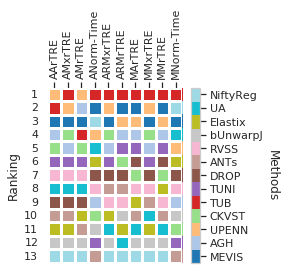

In [27]:
cols_ = list(filter(lambda c: 'Robust' not in c and 'land' not in c, cols_general))
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_]
dfx.columns = list(map(col_metric_rename, dfx.columns))
fig = draw_matrix_user_ranking(dfx, higher_better=False, fig=plt.figure(figsize=(4, 4)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_all.pdf'))

Show ranking for training and evalaution image pairs as heatmap

/home/jb/Dropbox/Workspace/BIRL/birl/utilities/drawing.py:494: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  fig, _ = plt.subplots(figsize=np.array(df_stat.as_matrix().shape[::-1]) * 0.35)


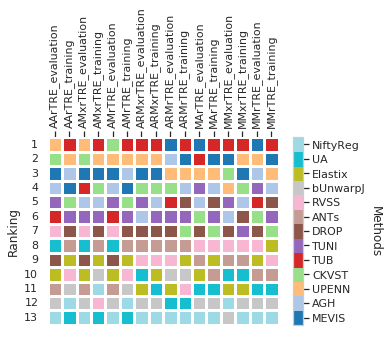

In [28]:
cols_ = list(filter(lambda c: 'Robust' not in c and 'land' not in c, cols_train_test))
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_]
dfx.columns = list(map(col_metric_rename, dfx.columns))
fig = draw_matrix_user_ranking(dfx, higher_better=False)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_train-test.pdf'))

### Visual statistic over tissue types (datasets)

Present some statistis depending on the tissue types...

In [29]:
cols_all = pd.DataFrame(user_aggreg).T.columns
# col_avg_med_tissue = sorted(filter(
#     lambda c: 'Median-rTRE_tissue' in c and not 'Rank' in c and 'Median-Median-' not in c, cols_all))
# col_robust_tissue = sorted(filter(
#     lambda c: 'Average-Robustness_tissue' in c and not 'Rank' in c, cols_all))
cols_avg_med_tissue_ = {st: sorted(filter(
    lambda c: 'Median-rTRE_%stissue' % st in c and not 'Rank' in c and 'Median-Median-' not in c, cols_all))
    for st in ('', VAL_STATUS_TRAIN + '_', VAL_STATUS_TEST + '_')}
cols_robust_tissue_ = {st: sorted(filter(
    lambda c: 'Average-Robustness_%stissue' % st in c and not 'Rank' in c, cols_all))
    for st in ('', VAL_STATUS_TRAIN + '_', VAL_STATUS_TEST + '_')}

"Avg. Median rTRE " with sample columns: ['Average-Median-rTRE_tissue_COAD', 'Average-Median-rTRE_tissue_gastric', 'Average-Median-rTRE_tissue_human-breast']
"Avg. Median rTRE (train)" with sample columns: ['Average-Median-rTRE_training_tissue_COAD', 'Average-Median-rTRE_training_tissue_gastric', 'Average-Median-rTRE_training_tissue_human-breast']
"Avg. Median rTRE (eval.)" with sample columns: ['Average-Median-rTRE_evaluation_tissue_COAD', 'Average-Median-rTRE_evaluation_tissue_gastric', 'Average-Median-rTRE_evaluation_tissue_human-breast']
"Avg. Robust " with sample columns: ['Average-Robustness_tissue_COAD', 'Average-Robustness_tissue_gastric', 'Average-Robustness_tissue_human-breast']
"Avg. Robust (train)" with sample columns: ['Average-Robustness_training_tissue_COAD', 'Average-Robustness_training_tissue_gastric', 'Average-Robustness_training_tissue_human-breast']
"Avg. Robust (eval.)" with sample columns: ['Average-Robustness_evaluation_tissue_COAD', 'Average-Robustness_evaluatio

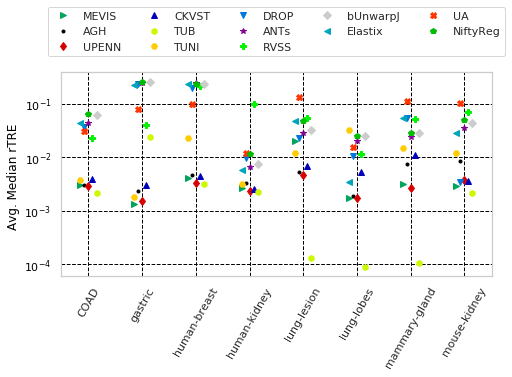

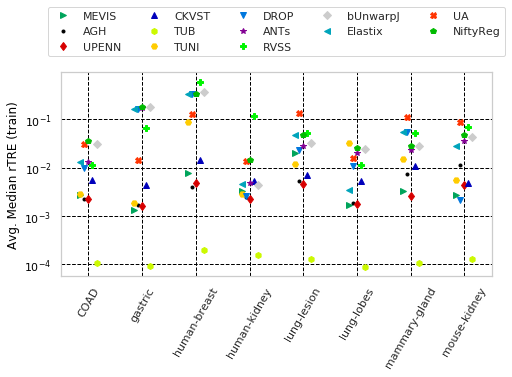

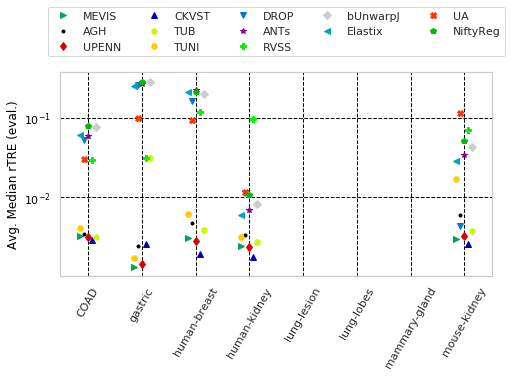

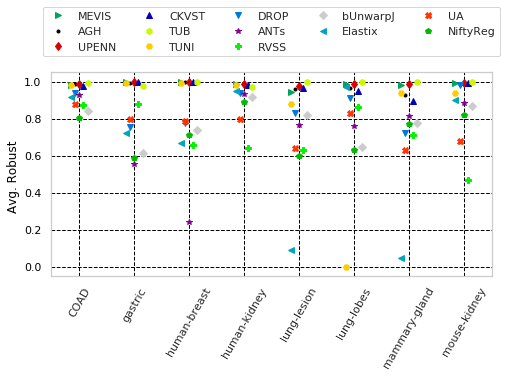

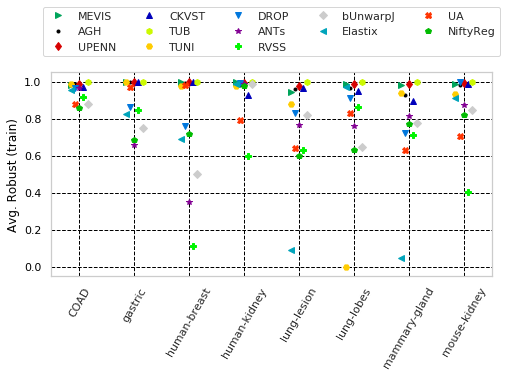

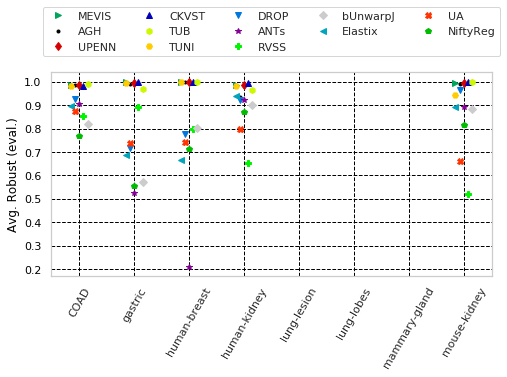

In [30]:
# [(col_avg_med_tissue, 'Avg. Median rTRE', 'Average-Median-rTRE__tissue_{}__All', True),
#  (col_robust_tissue, 'Avg. Robustness', 'Average-Robustness__tissue_{}__All', False),]
LUT_TRAIN_TEST = {
    VAL_STATUS_TRAIN: '(train)',
    VAL_STATUS_TEST: '(eval.)',
}

params_tuple = [(cols_avg_med_tissue_[st],
                 'Avg. Median rTRE %s' % LUT_TRAIN_TEST.get(st, ''),
                 'Average-Median-rTRE__tissue_{}__%s' % st, True) 
                for st in ('All', VAL_STATUS_TRAIN, VAL_STATUS_TEST)]
params_tuple += [(cols_robust_tissue_[st],
                  'Avg. Robust %s' % LUT_TRAIN_TEST.get(st, ''),
                  'Average-Robustness__tissue_{}__%s' % st, False)
                 for st in ('All', VAL_STATUS_TRAIN, VAL_STATUS_TEST)]

for cols, desc, drop, use_log in params_tuple:
    print('"%s" with sample columns: %s' % (desc, cols[:3]))
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]
    # colors = plt.get_cmap('nipy_spectral', len(dfx))
    fig, extras = draw_scatter_double_scale(
        dfx, colors=list_methods_colors(users_ranked), ax_decs={desc: None},
        idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 0.8, 6),
        legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
    # DEPRICATED visualisation
    # ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2 + 1, 5), grid=True)
    # ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
    extras['ax1'].set_xticks(range(len(cols)))
    extras['ax1'].set_xticklabels(list(map(lambda c: col_metric_rename(col_tissue_remane(c.replace(drop, ''))), cols)),
                                  rotation=45, ha="center")
    _format_ax(extras['ax1'], desc, use_log, vmax=None)
    name = ''.join(filter(lambda s: s not in '(.)', desc)).replace(' ', '-')
    fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-%s.pdf' % name),
                bbox_extra_artists=(extras['legend'],), bbox_inches='tight')

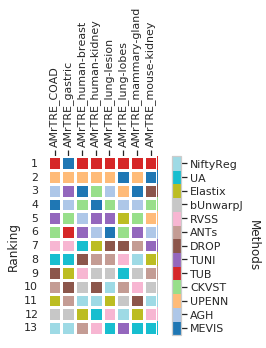

In [31]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_avg_med_tissue_['']]
dfx.columns = list(map(lambda c: col_metric_rename(c).replace('_tissue', '').replace('Average', 'Avg'),
                       dfx.columns))
fig = draw_matrix_user_ranking(dfx, higher_better=False, fig=plt.figure(figsize=(5, 5)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-avg.pdf'))

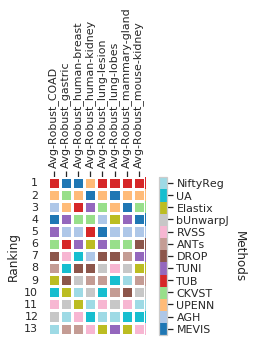

In [32]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_robust_tissue_['']]
dfx.columns = list(map(lambda c: col_tissue_remane(c).replace('Average-Robustness_tissue', 'Avg-Robust'),
                       dfx.columns))
fig = draw_matrix_user_ranking(dfx, higher_better=True, fig=plt.figure(figsize=(5, 5)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-robust.pdf'))

## Statistic per stain pairs

In [13]:
import re

STAINS = ['HE', 'ER', 'PR', 'CD1a', 'CD4', 'CD8', 'CD31', 'PAS', 'CD68',
          'EBV', 'MAS', 'PASM', 'KI67', 'CC10', 'CNEU', 'ASMA']
STAIN_LUT = {"CNEU": "HER2"}
def _filter_stain(name):
    regex = "(%s)" % '|'.join(STAINS)
    match = re.search(pattern=regex, string=name.upper())
    code = match.group(0) if match else re.sub(r"S\d(-v\d)?", r"DAB", name)
    return STAIN_LUT.get(code, code)

df_cases["stain-reference"] = df_cases["name-reference"].apply(_filter_stain)
df_cases["stain-source"] = df_cases["name-source"].apply(_filter_stain)
# print(df_cases["stain-reference"].unique())
nb_users = len(df_cases["method"].unique())

mx_stains = []
for st_ref, dfg in df_cases.groupby("stain-reference"):
    st_row = dict(dfg["stain-source"].value_counts())
    st_row.update({"stain-reference": st_ref})
    mx_stains.append(st_row)
df_stains_conf = pd.DataFrame(mx_stains).set_index("stain-reference")
df_stains_conf = (df_stains_conf[list(sorted(df_stains_conf.columns))] / nb_users).round()
df_stains_conf.to_csv(os.path.join(PATH_TEMP, 'stain-pairs_confuse.csv'))
display(df_stains_conf)

,ASMA,CC10,CD1a,CD31,CD4,CD68,CD8,DAB,EBV,ER,HE,HER2,KI67,MAS,PAS,PR
stain-reference,,,,,,,,,,,,,,,,
ASMA,1.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
CC10,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,6.0,NaN,NaN,3.0
CD1a,NaN,NaN,NaN,NaN,8.0,7.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD31,0.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,6.0,NaN,2.0,6.0
CD4,NaN,NaN,1.0,NaN,NaN,7.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD68,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD8,NaN,NaN,0.0,NaN,7.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
EBV,NaN,NaN,0.0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_cases["stain-pairs"] = df_cases.apply(lambda row: "-".join(sorted([row['stain-reference'], row['stain-source']])), axis=1)

# Show the count-stat
stain_pairs = [{'Status': "all"}]
stain_pairs[-1].update(dict(df_cases["stain-pairs"].value_counts()))
for st, dfg in df_cases.groupby("Status"):
    stain_pairs.append({'Status': st})
    stain_pairs[-1].update(dict(dfg["stain-pairs"].value_counts()))

df_stain_pairs = pd.DataFrame(stain_pairs).set_index('Status') / nb_users
df_stain_pairs.to_csv(os.path.join(PATH_TEMP, 'stain-pairs_counts.csv'))
display(df_stain_pairs)

,DAB-DAB,DAB-HE,HE-PR,ER-HE,PAS-PAS,MAS-PAS,CD31-PAS,HE-HE,CD1a-CD4,CD4-CD8,CD1a-CD68,CD4-CD68,...,ASMA-CD31,HER2-PR,ER-HER2,CD4-EBV,CD8-EBV,CD1a-EBV,CD68-EBV,ER-ER,CD31-CD31,ASMA-ASMA,CD1a-CD8,PR-PR
Status,,,,,,,,,,,,,,,,,,,,,,,,,
all,171.0,66.0,25.0,18.0,14.0,10.0,10.0,9.0,9.0,9.0,8.0,8.0,...,4.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
evaluation,87.0,66.0,10.0,10.0,11.0,5.0,4.0,NaN,9.0,8.0,8.0,NaN,...,2.0,NaN,NaN,1.0,3.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN
training,84.0,NaN,15.0,8.0,3.0,5.0,6.0,9.0,NaN,1.0,NaN,8.0,...,2.0,3.0,3.0,2.0,NaN,NaN,2.0,1.0,1.0,NaN,NaN,1.0


In [15]:
stats = []
for user, dfg in df_cases.groupby('method'):
    for stain, dfgg in dfg.groupby('stain-pairs'):
        stat = dict(dfgg.describe().T['mean'])
        stat.update({'method': user, 'stain-pairs': stain})
        stats.append(stat)
df_stats = pd.DataFrame(stats)
df_stats.head(3)

,index,scale-tissue,matched-landmarks,Robustness,Norm-Time_minutes,Affine-translation-X-Diff,Affine-translation-Y-Diff,Affine-scale-X-Diff,Affine-scale-Y-Diff,Affine-rotation-Diff,Affine-shear-Diff,rTRE-Mean_elastic,...,TRE-STD,rTRE-Median,TRE-Median,rTRE-Min,TRE-Min,rTRE-Max,TRE-Max,rTRE-Median_rank,rTRE-Max_rank,case,method,stain-pairs
0,463.00,25.0,1.0,1.000000,5.234309,-68.522467,103.017934,0.001765,-0.004129,-1.042002,0.012218,0.003905,...,70.070605,0.001111,13.237079,0.000089,1.060233,0.035879,427.503303,2.000,7.000,463.00,AGH,ASMA-ASMA
1,461.50,25.0,1.0,0.967803,11.100031,87.259917,-30.213029,0.041048,-0.032650,2.297837,0.020897,0.006532,...,125.167611,0.010752,128.108915,0.000201,2.391469,0.045603,543.357335,6.000,8.500,461.50,AGH,ASMA-CD31
2,460.75,25.0,1.0,0.971591,9.913527,67.857159,27.765855,0.011738,-0.019727,0.999659,0.015741,0.006957,...,101.380981,0.011249,133.693277,0.000622,7.403671,0.039665,470.752197,6.125,7.375,460.75,AGH,ASMA-PAS


In [16]:
def _tranpose_result_table(df, col_index, col_columns, col_values):
    table = []
    for idx, df_idx in df.groupby(col_index):
        row = [(col_index, idx)] + list(zip(df_idx[col_columns], df_idx[col_values]))
        table.append(dict(row))
    df = pd.DataFrame(table)
    return df.set_index(col_index)

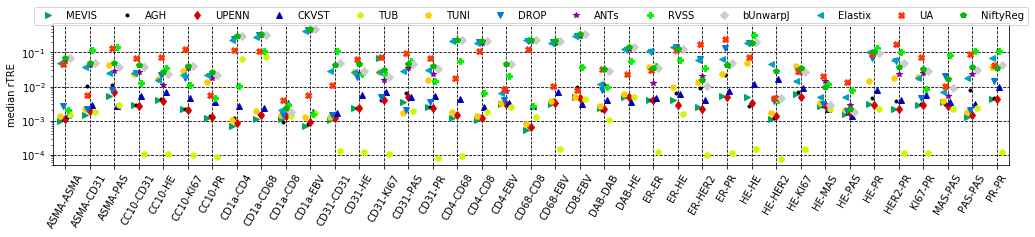

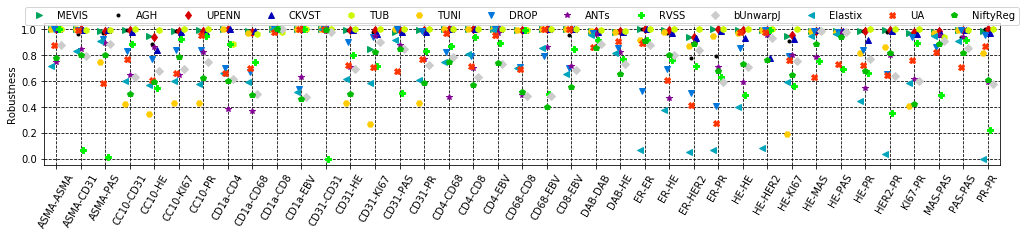

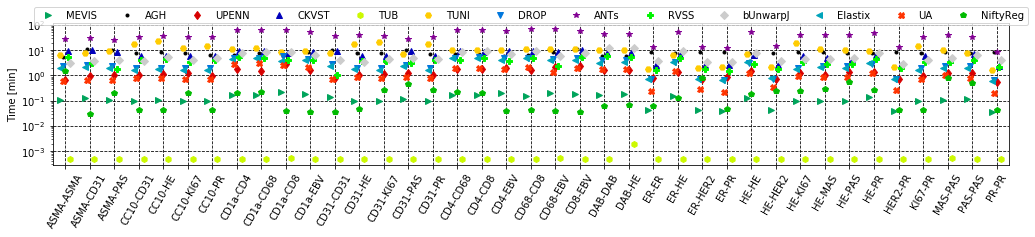

In [17]:
for metric, desc, use_log in [('rTRE-Median', 'median rTRE', True),
                              ('Robustness', 'Robustness', False),
                              ('Norm-Time_minutes', 'Time [min]', True)]:
    dfx = _tranpose_result_table(df_stats, 'method', 'stain-pairs', metric)
    # colors = plt.get_cmap('nipy_spectral', len(dfx))
    fig, extras = draw_scatter_double_scale(
        dfx.reindex(users_ranked), colors=list_methods_colors(users_ranked), ax_decs={desc: None},
        idx_markers=list_methods_markers(users_ranked), xlabel='Stain pairs', figsize=(1 + len(dfx.columns) * 0.37, 3.5),
        legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=14))
    extras['ax1'].set_xticks(range(len(dfx.columns)))
    extras['ax1'].set_xticklabels(list(dfx.columns), rotation=45, ha="center")
    extras['ax1'].set_xlim([-0.5, len(dfx.columns) - 0.5])
    _format_ax(extras['ax1'], desc, use_log, vmax=None)
    name = ''.join(filter(lambda s: s not in '(.)', desc)).replace(' ', '-')
    fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_stains-%s.pdf' % name),
                bbox_extra_artists=(extras['legend'],), bbox_inches='tight')

## Calculating pairwise significance

In [33]:
cases=[k for k in submissions[users[0]]['cases'].keys() if submissions[users[0]]['cases'][k][FIELD_STATUS] == 'evaluation' ]
print ('# cases: ', len(cases))

# cases:  251


Difference is not significant between ANTs and AGH for p=0.346996
Difference is not significant between CKVST and AGH for p=0.013812
Difference is not significant between CKVST and ANTs for p=0.415407
Difference is not significant between DROP and ANTs for p=0.444396
Difference is not significant between DROP and CKVST for p=0.080876
Difference is not significant between TUB and RVSS for p=0.325578
Difference is not significant between TUNI and TUB for p=0.422872
Difference is not significant between UA and TUB for p=0.078941
Difference is not significant between UA and TUNI for p=0.430366


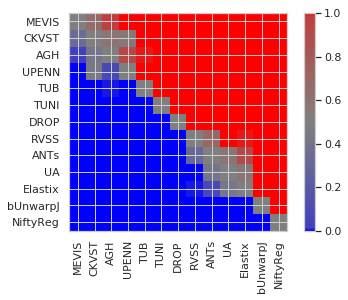

In [34]:
import matplotlib.colors
from scipy.stats import wilcoxon

# users_ = users_ranked
# JK requested having this order...
users_ = ['MEVIS', 'CKVST', 'AGH', 'UPENN', 'TUB', 'TUNI', 'DROP', 'RVSS', 'ANTs', 'UA', 'Elastix', 'bUnwarpJ', 'NiftyReg']
r = {m: list(map(lambda c: submissions[m]['cases'][c]['rTRE-Median'], cases)) for m in users}
x = r[users[0]]
y = r[users[1]]

ps = np.zeros((len(users), len(users)))
for i, j in ((i, j) for i in range(len(users)) for j in range(len(users))):
    if i != j:
        s, p = wilcoxon(r[users_[i]], r[users_[j]], alternative='greater')
        if i > j and p > 0.01:
            print('Difference is not significant between %s and %s for p=%f' % (users[i], users[j], p))
        ps[i, j] = p
    else:
        ps[i, j] = 0.5

cvals = [0., 0.01, 0.5, 0.99, 1.0]
colors = [[0, 0, 1], [0.25, 0.25, 0.75], [0.5, 0.5, 0.5], [0.75, 0.25, 0.25], [1., 0, 0]]
cvals_norm = plt.Normalize(min(cvals), max(cvals))
cvals_color = list(zip(map(cvals_norm, cvals), colors))   
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cvals_color)        
plt.imshow(ps, interpolation='nearest', cmap=cmap, norm=cvals_norm)
plt.colorbar()
_= plt.xticks(range(len(users)), users_, rotation=90)
_= plt.yticks(range(len(users)), users_)
plt.gca().get_figure().savefig(os.path.join(PATH_TEMP, 'wilcoxon_teams_rTRE.pdf'), bbox_inches='tight')